In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# GPUメモリの動的割り当て設定
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# データセットのパス設定
train_dir = 'dog_cat_photos/train'
test_dir = 'dog_cat_photos/test'

# MobileNetV2の入力サイズに合わせる
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

print("データセットの構造を確認...")
for root, dirs, files in os.walk('dog_cat_photos'):
    level = root.replace('dog_cat_photos', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # 最初の3ファイルのみ表示
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files)-3} more files')

データセットの構造を確認...
dog_cat_photos/
  test/
    cat/
      cat-151.jpg
      cat-152.jpg
      cat-153.jpg
      ... and 47 more files
    dog/
      dog-151.jpg
      dog-152.jpg
      dog-153.jpg
      ... and 47 more files
  train/
    cat/
      cat-001.jpg
      cat-002.jpg
      cat-003.jpg
      ... and 147 more files
    dog/
      dog-001.jpg
      dog-002.jpg
      dog-003.jpg
      ... and 147 more files


In [2]:
# データの前処理とデータ拡張
# 訓練用データジェネレータ（データ拡張あり）
train_datagen = ImageDataGenerator(
    rescale=1./255,           # 正規化
    rotation_range=20,        # 回転
    width_shift_range=0.2,    # 水平移動
    height_shift_range=0.2,   # 垂直移動
    shear_range=0.2,          # せん断変換
    zoom_range=0.2,           # ズーム
    horizontal_flip=True,     # 水平反転
    fill_mode='nearest',      # 欠損部分の補完方法
    validation_split=0.2      # 検証用データの分割
)

# テスト用データジェネレータ（正規化のみ）
test_datagen = ImageDataGenerator(rescale=1./255)

# 訓練用データの読み込み
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# 検証用データの読み込み
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# テスト用データの読み込み
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"訓練データ数: {train_generator.samples}")
print(f"検証データ数: {validation_generator.samples}")
print(f"テストデータ数: {test_generator.samples}")
print(f"クラス: {train_generator.class_indices}")

Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
訓練データ数: 240
検証データ数: 60
テストデータ数: 100
クラス: {'cat': 0, 'dog': 1}


In [3]:
# MobileNetV2ベースモデルの構築
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# ベースモデルの重みを固定
base_model.trainable = False

# モデルの構築
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# モデルのコンパイル
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# モデルの構造を表示
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# コールバック関数の設定
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# モデルの訓練
print("モデルの訓練を開始...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

モデルの訓練を開始...


c:\Users\U30010N1255\Downloads\pythondev\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5337 - loss: 0.8156 - val_accuracy: 0.5938 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 2/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.6562 - loss: 0.6183

c:\Users\U30010N1255\Downloads\pythondev\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6562 - loss: 0.6183 - val_accuracy: 0.6875 - val_loss: 0.6153 - learning_rate: 1.0000e-04
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 966ms/step - accuracy: 0.6010 - loss: 0.6725 - val_accuracy: 0.5625 - val_loss: 0.7260 - learning_rate: 1.0000e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.7812 - loss: 0.5130 - val_accuracy: 0.6250 - val_loss: 0.6350 - learning_rate: 1.0000e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6779 - loss: 0.5615 - val_accuracy: 0.7500 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.7188 - loss: 0.5975 - val_accuracy: 0.6250 - val_loss: 0.5972 - learning_rate: 1.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 922ms/step - accuracy: 0.8214 - loss: 0.4587 - val_accuracy: 0.7188 - val_loss: 0.6045 - learning_rate: 1.0000e-04
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6875 - loss: 0.6657 - val_

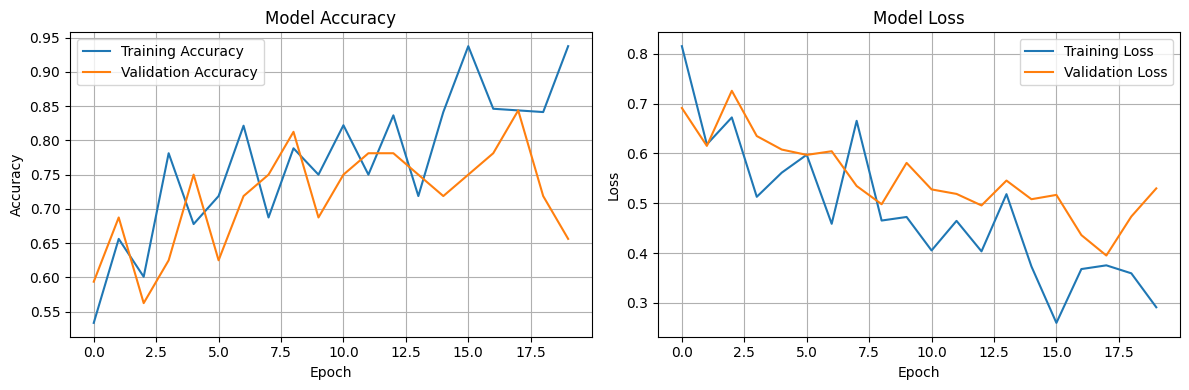

In [5]:
# 訓練履歴の可視化
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 精度の推移
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # 損失の推移
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [6]:
# ファインチューニング（オプション）
print("ファインチューニングを実行...")

# ベースモデルの一部レイヤーを訓練可能にする
base_model.trainable = True

# 最後の数層のみ訓練可能にする
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# より低い学習率で再コンパイル
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ファインチューニングの実行
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

ファインチューニングを実行...
Epoch 20/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7788 - loss: 0.5002 - val_accuracy: 0.6875 - val_loss: 0.5573 - learning_rate: 1.0000e-05
Epoch 21/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.8125 - loss: 0.5022 - val_accuracy: 0.7188 - val_loss: 0.5129 - learning_rate: 1.0000e-05
Epoch 22/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7991 - loss: 0.4557 - val_accuracy: 0.6562 - val_loss: 0.5118 - learning_rate: 1.0000e-05
Epoch 23/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8750 - loss: 0.3575 - val_accuracy: 0.8125 - val_loss: 0.4208 - learning_rate: 5.0000e-06
Epoch 24/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8413 - loss: 0.4169 - val_accuracy: 0.7812 - val_loss: 0.5057 - learning_rate: 5.0000e-06


テストデータでの最終評価...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.9200 - loss: 0.3067

=== 最終結果 ===
テスト損失: 0.3067
テスト精度: 0.9200 (92.00%)
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 831ms/step


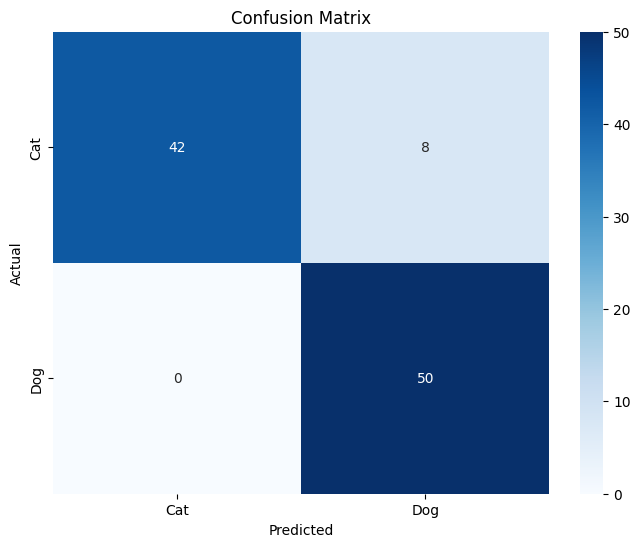


=== 分類レポート ===
              precision    recall  f1-score   support

         Cat       1.00      0.84      0.91        50
         Dog       0.86      1.00      0.93        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



In [7]:
# テストデータでの評価
print("テストデータでの最終評価...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n=== 最終結果 ===")
print(f"テスト損失: {test_loss:.4f}")
print(f"テスト精度: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# 予測結果の詳細分析
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes

# 混同行列の作成
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
class_names = ['Cat', 'Dog']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 分類レポート
print("\n=== 分類レポート ===")
print(classification_report(true_classes, predicted_classes, 
                          target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


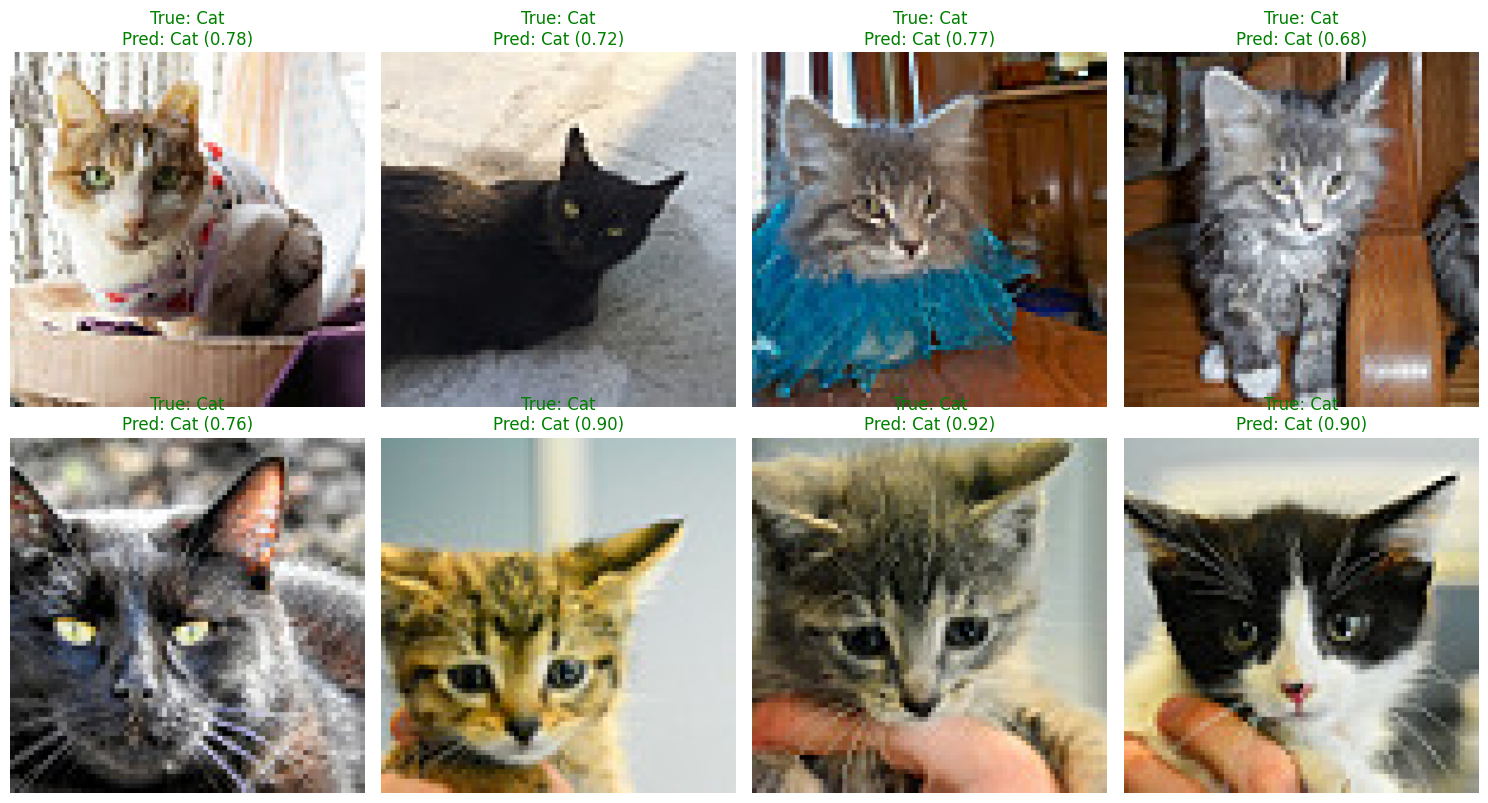

In [8]:
# 予測例の表示
def show_predictions(generator, model, num_images=8):
    plt.figure(figsize=(15, 8))
    
    # バッチを取得
    images, labels = next(generator)
    predictions = model.predict(images)
    
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        
        true_class = 'Dog' if labels[i] == 1 else 'Cat'
        pred_class = 'Dog' if predictions[i] > 0.5 else 'Cat'
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]
        
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence:.2f})', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# テストデータでの予測例を表示
test_generator.reset()  # ジェネレータをリセット
show_predictions(test_generator, model)

In [9]:
# モデルの保存
model.save('dog_cat_classifier.h5')
print("モデルを 'dog_cat_classifier.h5' として保存しました")

# 最終的な評価結果の再表示
print(f"\n=== 最終評価結果 ===")
print(f"テスト精度: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"使用したモデル: MobileNetV2 (転移学習)")
print(f"データ拡張: 回転、移動、せん断、ズーム、反転")
print(f"画像サイズ: {IMG_SIZE}x{IMG_SIZE}")
print(f"バッチサイズ: {BATCH_SIZE}")

モデルを 'dog_cat_classifier.h5' として保存しました

=== 最終評価結果 ===
テスト精度: 0.9200 (92.00%)
使用したモデル: MobileNetV2 (転移学習)
データ拡張: 回転、移動、せん断、ズーム、反転
画像サイズ: 224x224
バッチサイズ: 32
